# Data preparation

In [18]:
import pickle
from pathlib import Path
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np



import configuration as config

## 1. Load combined data

In [19]:
data_df=pd.read_csv(config.COMBINED_DATAFILE)

## 2. Combine origin/destination to 'route'

In [20]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    LGA         ORF          1338.0      N915XJ         0
1    DTW         MSN           821.0      N907XJ         0
2    MSP         BIS           901.0      N166PQ         0
3    BIS         MSP          1135.0      N166PQ         0
4    MSN         DTW           928.0      N907XJ         0


In [21]:
airport_features=['origin','destination']

print('Unique levels by feature')
data_df[airport_features].nunique()


Unique levels by feature


origin         5885
destination    5915
dtype: int64

In [22]:
print(data_df['origin'].value_counts().head(15))


origin
ATL    29050
ORD    26221
DFW    25948
DEN    25883
CLT    21120
PHX    17444
LAX    16778
LAS    15759
SEA    14375
IAH    13797
MCO    13604
LGA    13009
SFO    12223
BOS    11879
EWR    11804
Name: count, dtype: int64


In [23]:
print(data_df['destination'].value_counts().head(15))

destination
ATL    29041
ORD    26187
DFW    25956
DEN    25850
CLT    21104
PHX    17444
LAX    16785
LAS    15753
SEA    14373
IAH    13796
MCO    13614
LGA    13028
SFO    12229
BOS    11870
EWR    11798
Name: count, dtype: int64


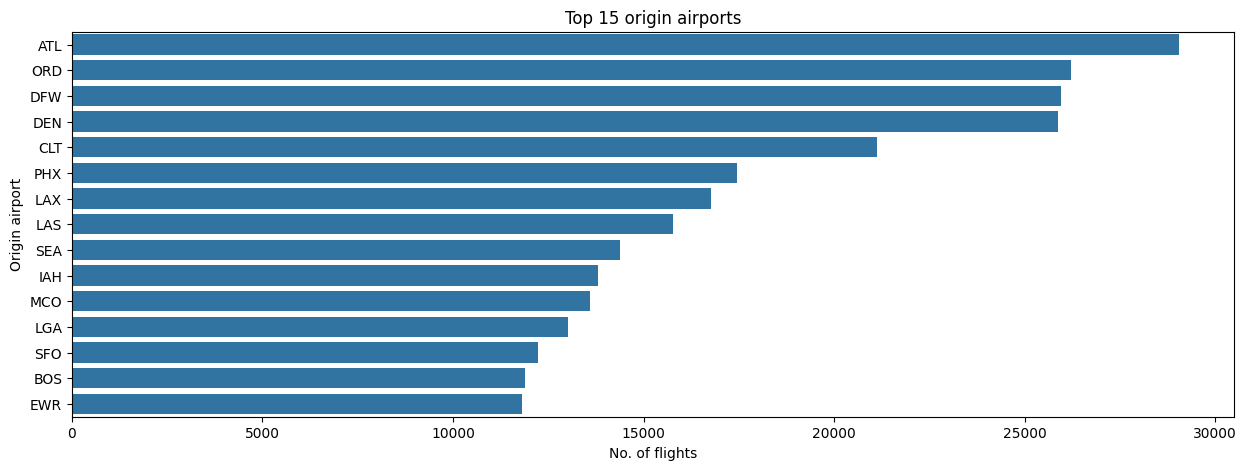

In [24]:

# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['origin'].value_counts().head(15).index
sns.countplot(data=data_df, y='origin', order=level_counts)

plt.title('Top 15 origin airports')
plt.xlabel('No. of flights')
plt.ylabel('Origin airport');
plt.show()


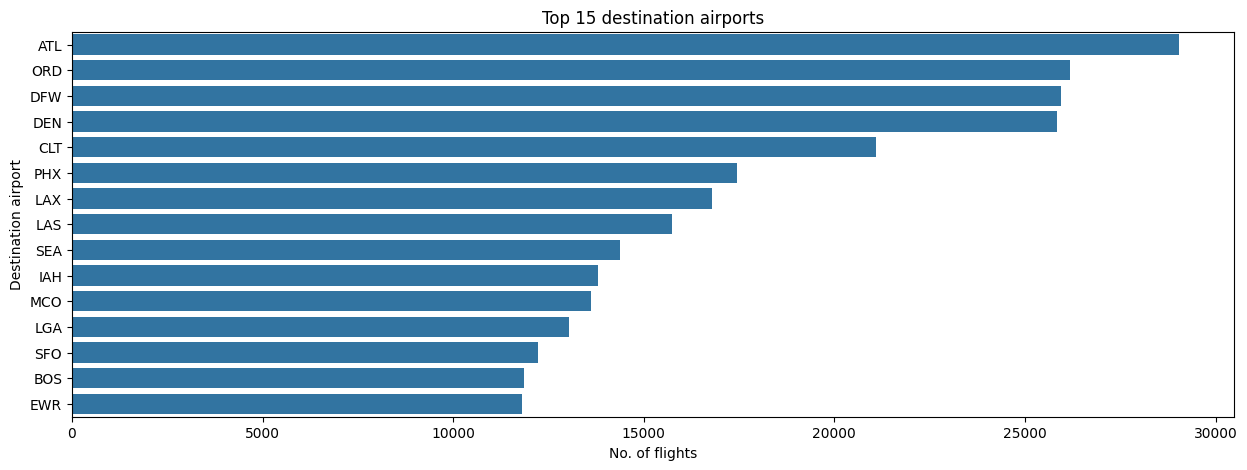

In [25]:
# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['destination'].value_counts().head(15).index
sns.countplot(data=data_df, y='destination', order=level_counts)

plt.title('Top 15 destination airports')
plt.xlabel('No. of flights')
plt.ylabel('Destination airport');
plt.show()

In [26]:
data_df['incident'].value_counts()

incident
0    631177
1     14393
Name: count, dtype: int64

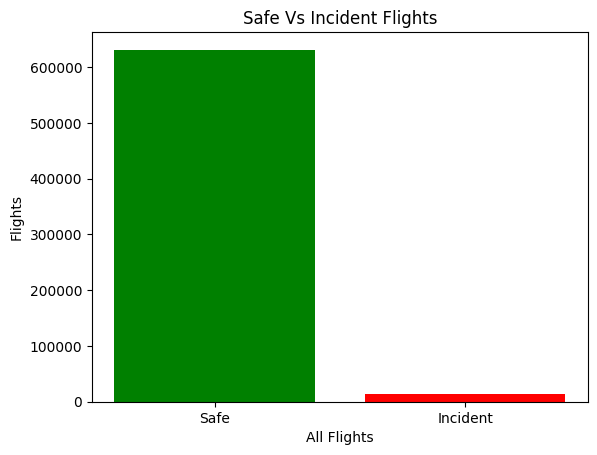

In [27]:
level_counts=data_df['incident'].value_counts()
new_labels = ['Safe', 'Incident']
plt.bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color=('green', 'red'))
plt.title('Safe Vs Incident Flights')
plt.xlabel('All Flights')
plt.xticks(range(len(level_counts)), new_labels)
plt.ylabel('Flights')
plt.show()


In [12]:
label='incident'
route=['origin','destination']


In [5]:
data_df['route'] = data_df['origin'] + ' to ' + data_df['destination']

In [6]:
print(data_df.head())

  origin destination  departure_time tail_number  incident       route
0    LGA         ORF          1338.0      N915XJ         0  LGA to ORF
1    DTW         MSN           821.0      N907XJ         0  DTW to MSN
2    MSP         BIS           901.0      N166PQ         0  MSP to BIS
3    BIS         MSP          1135.0      N166PQ         0  BIS to MSP
4    MSN         DTW           928.0      N907XJ         0  MSN to DTW


In [28]:
data_df['departure_time'].head(10)

0    1338.0
1     821.0
2     901.0
3    1135.0
4     928.0
5    1235.0
6    1146.0
7    1144.0
8    1214.0
9    1141.0
Name: departure_time, dtype: float64

In [29]:
cyclical_encoded_data_df = data_df.copy()

cyclical_encoded_data_df.head().T


,0,1,2,3,4
origin,LGA,DTW,MSP,BIS,MSN
destination,ORF,MSN,BIS,MSP,DTW
departure_time,1338.0,821.0,901.0,1135.0,928.0
tail_number,N915XJ,N907XJ,N166PQ,N166PQ,N907XJ
incident,0,0,0,0,0


In [33]:
# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    hhmm_int = int(hhmm)
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

# Add minutes since midnight column
cyclical_encoded_data_df['Time'] = cyclical_encoded_data_df['departure_time'].apply(hhmm_to_minutes)

# Add formatted time label for display
cyclical_encoded_data_df['time_label'] = cyclical_encoded_data_df['departure_time'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
cyclical_encoded_data_df['time_sin'] = np.sin(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)  # 1440 minutes in a day
cyclical_encoded_data_df['time_cos'] = np.cos(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(cyclical_encoded_data_df.head(3).round(4).T)



DataFrame with cyclical time encoding:
                     0       1       2
origin             LGA     DTW     MSP
destination        ORF     MSN     BIS
departure_time  1338.0   821.0   901.0
tail_number     N915XJ  N907XJ  N166PQ
incident             0       0       0
Time             818.0   501.0   541.0
time_label       13:38   08:21   09:01
time_sin       -0.4147  0.8166   0.704
time_cos         -0.91 -0.5771 -0.7102


In [35]:
# Visualize the encoding
plt.figure(figsize=(10, 6))
plt.scatter(cyclical_encoded_data_df['time_sin'], cyclical_encoded_data_df['time_cos'], c=range(len(cyclical_encoded_data_df)), cmap='hsv', s=100)

# Add labels for each point
for i in cyclical_encoded_data_df.index:
    plt.annotate(f"{cyclical_encoded_data_df.loc[i, 'departure_time']} ({cyclical_encoded_data_df.loc[i, 'time_label']})", 
                 (cyclical_encoded_data_df.loc[i, 'time_sin'], cyclical_encoded_data_df.loc[i, 'time_cos']),
                 xytext=(10, 5),
                 textcoords='offset points')

# Add reference circle and axes
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_patch(circle)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Cyclical Encoding of HHMM Time Format (Float Values)')
plt.xlabel('sin(time)')
plt.ylabel('cos(time)')
plt.axis('equal')
plt.tight_layout()
plt.show()

: 

DataFrame with cyclical time encoding:
     hhmm  other_feature1 other_feature2  minutes time_label  time_sin  \
0  1338.0            10.5              A      818      13:38   -0.4147   
1   355.0            20.3              B      235      03:55    0.8549   
2   821.0            15.7              C      501      08:21    0.8166   
3   921.0             8.9              A      561      09:21    0.6394   
4  2315.0            12.1              B     1395      23:15   -0.1951   

   time_cos  
0   -0.9100  
1    0.5188  
2   -0.5771  
3   -0.7688  
4    0.9808  


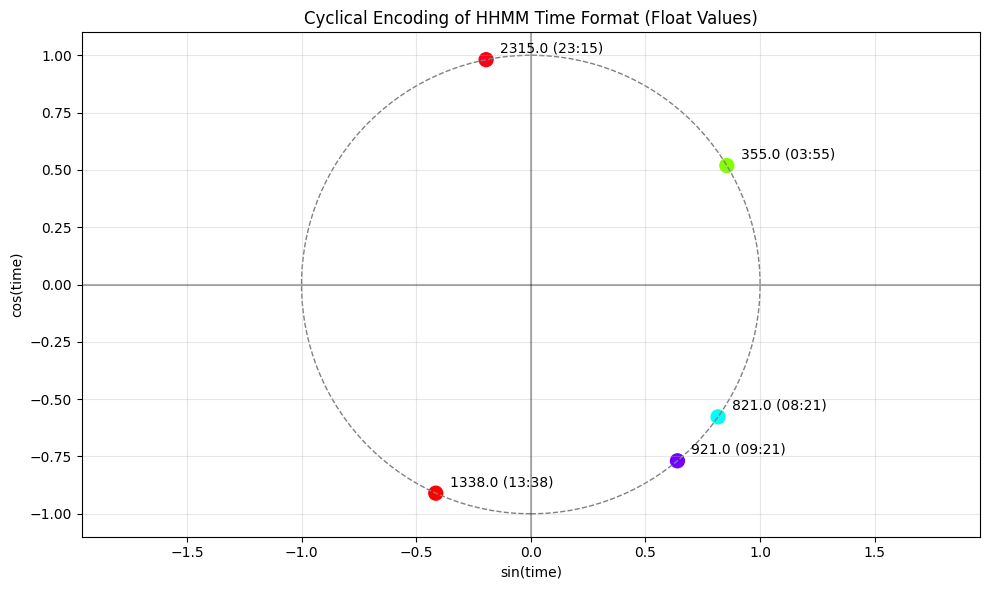

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame with HHMM times as float values
# In a real scenario, you would use your existing DataFrame instead
sample_data = {
    'hhmm': [1338.0, 355.0, 821.0, 921.0, 2315.0],
    'other_feature1': [10.5, 20.3, 15.7, 8.9, 12.1],
    'other_feature2': ['A', 'B', 'C', 'A', 'B']
}
df = pd.DataFrame(sample_data)

# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    # Convert float to int before division to avoid potential issues
    hhmm_int = int(hhmm)
    hours = hhmm_int // 100
    minutes = hhmm_int % 100
    return hours * 60 + minutes

# Add minutes since midnight column
df['minutes'] = df['hhmm'].apply(hhmm_to_minutes)

# Add formatted time label for display
df['time_label'] = df['hhmm'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
df['time_sin'] = np.sin(2 * np.pi * df['minutes'] / 1440)  # 1440 minutes in a day
df['time_cos'] = np.cos(2 * np.pi * df['minutes'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(df.round(4))

# Visualize the encoding
plt.figure(figsize=(10, 6))
plt.scatter(df['time_sin'], df['time_cos'], c=range(len(df)), cmap='hsv', s=100)

# Add labels for each point
for i in df.index:
    plt.annotate(f"{df.loc[i, 'hhmm']} ({df.loc[i, 'time_label']})", 
                 (df.loc[i, 'time_sin'], df.loc[i, 'time_cos']),
                 xytext=(10, 5),
                 textcoords='offset points')

# Add reference circle and axes
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_patch(circle)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Cyclical Encoding of HHMM Time Format (Float Values)')
plt.xlabel('sin(time)')
plt.ylabel('cos(time)')
plt.axis('equal')
plt.tight_layout()
plt.show()


DataFrame with cyclical time encoding:
     hhmm  other_feature1 other_feature2  minutes time_label  time_sin  \
0  1338.0            10.5              A      818      13:38   -0.4147   
1   355.0            20.3              B      235      03:55    0.8549   
2   821.0            15.7              C      501      08:21    0.8166   
3   921.0             8.9              A      561      09:21    0.6394   
4  2315.0            12.1              B     1395      23:15   -0.1951   

   time_cos  
0   -0.9100  
1    0.5188  
2   -0.5771  
3   -0.7688  
4    0.9808  


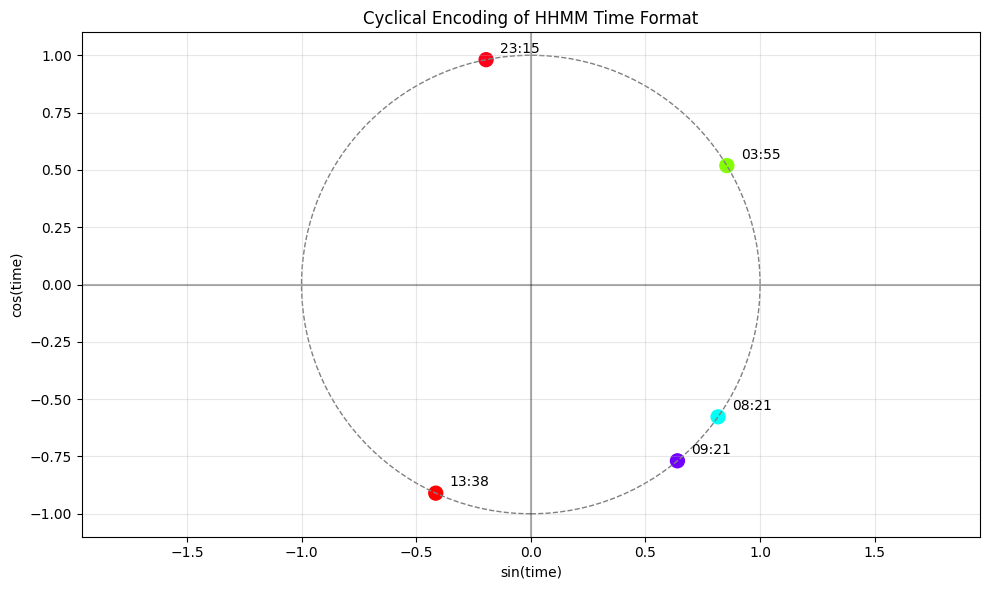

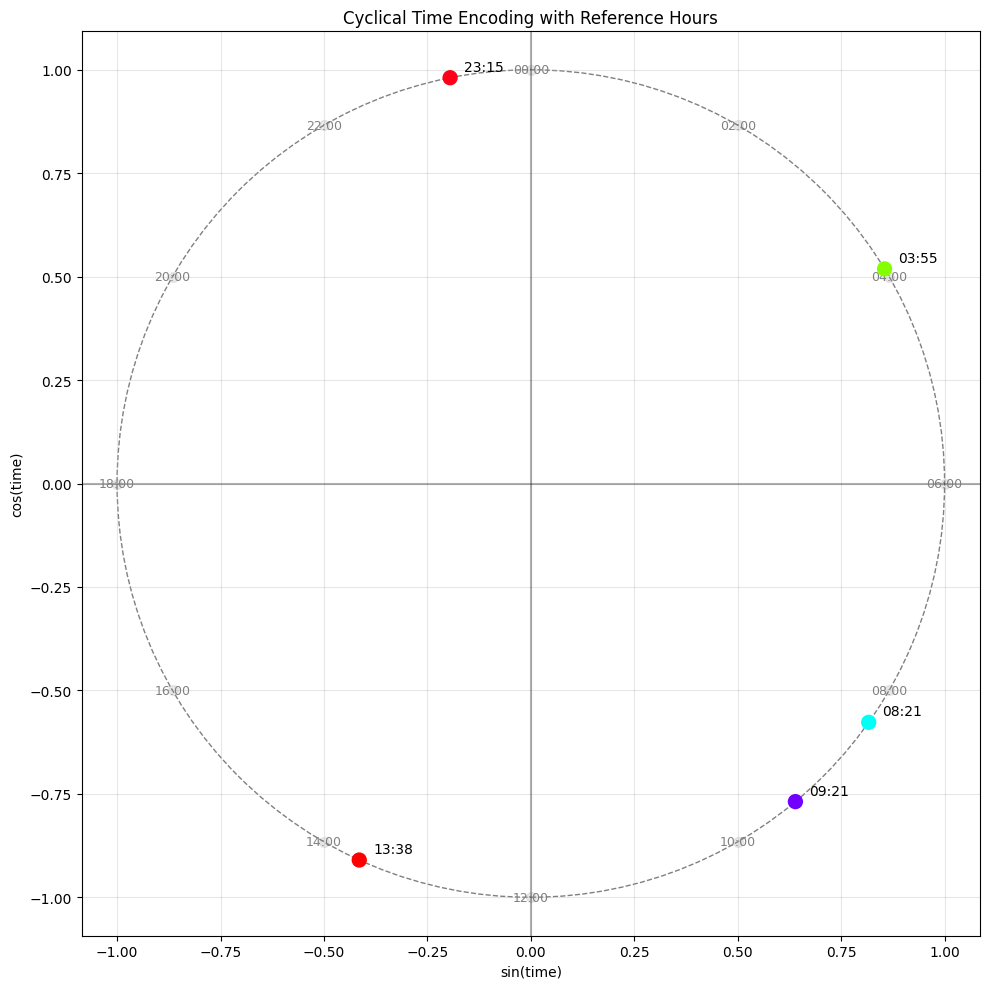

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame with HHMM times as float values
# In a real scenario, you would use your existing DataFrame instead
sample_data = {
    'hhmm': [1338.0, 355.0, 821.0, 921.0, 2315.0],
    'other_feature1': [10.5, 20.3, 15.7, 8.9, 12.1],
    'other_feature2': ['A', 'B', 'C', 'A', 'B']
}
df = pd.DataFrame(sample_data)

# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    # Convert float to int before division to avoid potential issues
    hhmm_int = int(hhmm)
    hours = hhmm_int // 100
    minutes = hhmm_int % 100
    return hours * 60 + minutes

# Add minutes since midnight column
df['minutes'] = df['hhmm'].apply(hhmm_to_minutes)

# Add formatted time label for display
df['time_label'] = df['hhmm'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
df['time_sin'] = np.sin(2 * np.pi * df['minutes'] / 1440)  # 1440 minutes in a day
df['time_cos'] = np.cos(2 * np.pi * df['minutes'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(df.round(4))

# Visualize the encoding
plt.figure(figsize=(10, 6))
plt.scatter(df['time_sin'], df['time_cos'], c=range(len(df)), cmap='hsv', s=100)

# Add labels for each point
for i in df.index:
    plt.annotate(f"{df.loc[i, 'time_label']}", 
                 (df.loc[i, 'time_sin'], df.loc[i, 'time_cos']),
                 xytext=(10, 5),
                 textcoords='offset points')

# Add reference circle and axes
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_patch(circle)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Cyclical Encoding of HHMM Time Format')
plt.xlabel('sin(time)')
plt.ylabel('cos(time)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Add a second visualization with reference times around the circle
plt.figure(figsize=(10, 10))

# Add reference times every 2 hours for context
hours = np.arange(0, 24, 2)
for hour in hours:
    minutes = hour * 60
    sin_val = np.sin(2 * np.pi * minutes / 1440)
    cos_val = np.cos(2 * np.pi * minutes / 1440)
    plt.scatter(sin_val, cos_val, color='lightgray', s=50, alpha=0.5)
    plt.annotate(f"{hour:02d}:00", (sin_val, cos_val), 
                 fontsize=9, ha='center', va='center', color='gray')

# Plot our data points
plt.scatter(df['time_sin'], df['time_cos'], c=range(len(df)), cmap='hsv', s=100, zorder=10)
for i in df.index:
    plt.annotate(f"{df.loc[i, 'time_label']}", 
                 (df.loc[i, 'time_sin'], df.loc[i, 'time_cos']),
                 xytext=(10, 5), textcoords='offset points', zorder=11)

# Add reference circle and axes
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
plt.gca().add_patch(circle)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Cyclical Time Encoding with Reference Hours')
plt.xlabel('sin(time)')
plt.ylabel('cos(time)')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 3. Encode departure time

In [ ]:
import numpy as np

departure_times = data_df['departure_time'].copy() 

def time_to_seconds(time_str):
    parts = time_str.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = int(parts[2]) if len(parts) > 2 else 0
    return hours * 3600 + minutes * 60 + seconds

if departure_times.dtype == 'object':
    total_seconds = departure_times.apply(time_to_seconds)
else:
    total_seconds = departure_times

max_seconds_in_day = 24 * 3600
normalized_time = total_seconds / max_seconds_in_day

data_df['departure_time_sin'] = np.sin(2 * np.pi * normalized_time)
data_df['departure_time_cos'] = np.cos(2 * np.pi * normalized_time)

print(data_df[['departure_time', 'departure_time_sin', 'departure_time_cos']].head())

   departure_time  departure_time_sin  departure_time_cos
0          1338.0            0.097149            0.995270
1           821.0            0.059669            0.998218
2           901.0            0.065476            0.997854
3          1135.0            0.082446            0.996596
4           928.0            0.067435            0.997724


In [16]:
# 1. Combine 'departure_time_sin' and 'departure_time_cos' into a list of tuples
data_df['departure_time'] = list(zip(data_df['departure_time_sin'], data_df['departure_time_cos']))

# 2. Remove the original sine and cosine columns
data_df = data_df.drop(['departure_time_sin', 'departure_time_cos'], axis=1)

# Now your DataFrame 'data_df' will have a single 'departure_time' column
# containing tuples of (sin_value, cos_value).

In [17]:
data_df.head

<bound method NDFrame.head of        origin destination                             departure_time  \
0         LGA         ORF  (0.09714864061033167, 0.9952698838142168)   
1         DTW         MSN  (0.05966933989164823, 0.9982181975284237)   
2         MSP         BIS  (0.06547569540580747, 0.9978541643502451)   
3         BIS         MSP  (0.08244584060375283, 0.9965955465318619)   
4         MSN         DTW  (0.06743485000226511, 0.9977236796854989)   
...       ...         ...                                        ...   
645565    3G3         POV  (0.07592141872045746, 0.9971138040261367)   
645566   KBFI        KAPA  (0.13398618541829205, 0.9909831997148363)   
645567   PASX         PVT   (0.15930686806752256, 0.987229113117374)   
645568   PACM        PANC  (0.009817319337149617, 0.999951808959328)   
645569    LBL         LBL   (0.1254775294722748, 0.9920964618410523)   

       tail_number  incident         route  
0           N915XJ         0    LGA to ORF  
1           N90

## 4. Clean up features

In [5]:
# Your code here... For now, we don't need the tail number. Also 
# get rid of unencoded versions of the features we just handled.

## 5. Train-test split

In [6]:
# Your code here... you know the drill!

## 6. Encode route

In [7]:
# Your code here... Hint: try OrdinalEncoder(), OneHotEncoder() seems like it's the right
# thing to do - but think about why it might be problematic with this data!

## 7. Save

In [8]:
Path(config.PROCESSED_DATA_DIRECTORY).mkdir(exist_ok=True)

data_df.to_csv(config.ENCODED_DATAFILE)
train_df.to_csv(config.TRAINING_DATAFILE)
test_df.to_csv(config.TESTING_DATAFILE)

NameError: name 'train_df' is not defined